# General Statistics

In [6]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as datetime
%matplotlib inline
from scipy.signal import argrelextrema

In [14]:
# Read in files
# Read in data
towerseasons = pd.read_csv('tower_seasons_2019-11-21.csv', parse_dates=['max_canopy_date'])
towerweekly = pd.read_csv('tower_weekly_2019-11-22.csv', parse_dates=['date'])
towers = pd.read_csv('towers_2019-11-21.csv', parse_dates = ['installed_at'])

final = pd.read_csv('final_table.csv')
towerseasons_clean = pd.read_csv('towerseasons_clean.csv',parse_dates=['max_canopy_date'])
towerweekly_clean = pd.read_csv('towerweekly_clean.csv',parse_dates=['date'])
towers_clean = pd.read_csv('towers_clean.csv',parse_dates = ['installed_at'])

## Identifying and Visualizing Local Minima and Maxima

In [4]:
# To ignore warnings 
import warnings
warnings.filterwarnings('ignore')

# Subset to test individual towers
data = towerweekly_clean[towerweekly_clean.tower_id == 10]
data.head(2)

# Look at data types
# print ('\n Data Types:')
# print (data.dtypes)

# Set date as index
data.set_index('date', inplace=True)

# Check datatype of index
# data.index

# Convert to time series:
# ts = data[['irrigation_mm', 'actual_precip_mm', 'pri', 'tower_id']]
# ts = data['pri']
# ts.head(10)

# plt.plot(ts)
# ts = pd.DataFrame(ts)
# df = ts.reset_index()

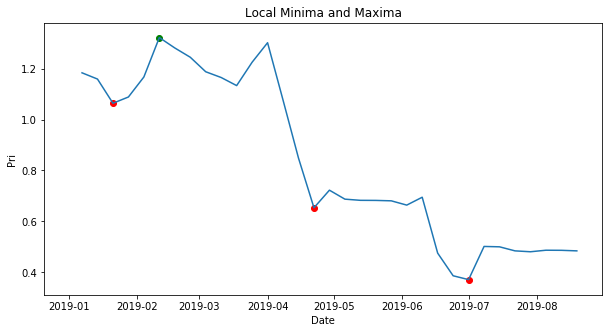

In [7]:
n = 7 
# Number of points to be checked before and after 
# How many points on each side to use for the comparison to consider comparator(n, n+x) to be True
# Find local peaks
data['min'] = data.iloc[argrelextrema(data.pri.values, np.less_equal, order=n)[0]]['pri']
data['max'] = data.iloc[argrelextrema(data.pri.values, np.greater_equal, order=n)[0]]['pri']

# Plot results
plt.figure(figsize=(10,5))
plt.scatter(data.index, data['min'], c='r')
plt.scatter(data.index, data['max'], c='g')
plt.plot(data.index, data['pri'])
plt.xlabel('Date')
plt.ylabel('Pri')
plt.title('Local Minima and Maxima')
plt.show()

In [8]:
len(towerweekly_clean.tower_id.unique())
# 1207 unique towers

1207

In [9]:
# Watch out, it will go through 1,207 towers which might take a few minutes
def find_max(data, n):

    for i in towerweekly_clean['tower_id'].unique():
        
        data = towerweekly_clean[towerweekly_clean.tower_id == i]
        data.set_index('date', inplace=True)
        
        n=n # number of points to be checked before and after 
        # Find local peaks
        data['min'] = data.iloc[argrelextrema(data.pri.values, np.less_equal, order=n)[0]]['pri']
        data['max'] = data.iloc[argrelextrema(data.pri.values, np.greater_equal, order=n)[0]]['pri']

        # Plot results
        plt.figure(figsize=(10,5))
        plt.scatter(data.index, data['min'], c='r')
        plt.scatter(data.index, data['max'], c='g')
        plt.plot(data.index, data['pri'])
        plt.xlabel('Dates')
        plt.ylabel('Pri')
        plt.title('Tower ID')
        plt.show()

In [ ]:
# find_max(data, n)

## Performing a simple groupby to view the mean and standard deviation in max canopy date per crop and plot 

In [10]:
# This dataset is best for a more simple statistical approach.
# Looks at historic data, looks at similar sites.
# If no historical data, determines a window for looking for the max canopy using median  + 1 SD.
# Uses tower seasons
towerseasons_clean['year'].unique()

array([2019, 2015, 2017, 2018, 2016, 2014])

In [15]:
# Merging tower seasons and towers
towers.head()
towerseasons.head()

# Right merge to keep all keys from towerseasons
full_towers = pd.merge(towers, towerseasons, on='tower_id', how='right')
full_towers.head()
full_towers.shape

# Totalling NA values 
full_towers.isna().sum()

tower_id                 0
crop                    35
metacrop                35
betweenrowft            28
slope                   28
aspect                  28
region                  28
subregion               28
installed_at            28
young_plant            212
trellis_type          3582
year                     0
actual_max_canopy    10468
max_canopy_date       1492
dtype: int64

In [16]:
# Totaling clean values
full_towers_clean = full_towers.dropna()
full_towers_clean.head()

,tower_id,crop,metacrop,betweenrowft,slope,aspect,region,subregion,installed_at,young_plant,trellis_type,year,actual_max_canopy,max_canopy_date
4,4068,grape,vine,5.0,4.0,85.0,NCoast,napa,2019-04-03 18:42:35,True,vsp,2019,1.033074,2019-06-17
9,3490,grape,vine,8.0,0.0,297.0,NCoast,napa,2018-04-19 22:57:42,False,vsp,2018,0.919281,2018-06-25
11,3490,grape,vine,8.0,0.0,297.0,NCoast,napa,2018-04-19 22:57:42,False,vsp,2019,1.031695,2019-06-24
19,1297,grape,vine,10.0,1.0,252.0,NCoast,napa,2016-05-20 19:16:29,False,lyre,2019,0.943267,2019-07-08
22,1297,grape,vine,10.0,1.0,252.0,NCoast,napa,2016-05-20 19:16:29,False,lyre,2016,0.929295,2016-06-05


In [17]:
# Convert max_canopy_date to numeric
# Now have a new column 'dayofyear' equivalent to the day of year
full_towers['dayofyear'] = full_towers['max_canopy_date'].dt.dayofyear

In [18]:
# Group by statements
full_towers_group = full_towers.groupby('tower_id')['max_canopy_date'].count()
full_towers_group.head()

tower_id
5     7
6     6
10    9
11    9
12    5
Name: max_canopy_date, dtype: int64

In [19]:
full_towers_summary =  full_towers.groupby(by='tower_id').agg({'dayofyear': ['count', 'mean', 'std']}).rename(columns={'count': 'yrs_of_data', 'mean': 'average_max_date', 'std':'std_max_date'})
full_towers_summary.head(10)

dayofyear                              
         yrs_of_data average_max_date std_max_date
tower_id                                          
5                  7       174.142857    14.484803
6                  6       150.166667    20.769368
10                 9       172.888889    14.084073
11                 9       187.222222    19.696305
12                 5       182.200000    17.626684
13                 9       181.666667    13.674794
14                 8       195.625000    11.783008
15                 9       160.555556    21.054163
16                 9       167.444444    16.860539
17                 9       179.000000    22.891046

In [20]:
mean = np.mean(full_towers_summary['dayofyear'][['std_max_date']])
mean

std_max_date    21.165978
dtype: float64

In [21]:
full_towers_summary.describe()

dayofyear                              
       yrs_of_data average_max_date std_max_date
count  1815.000000      1745.000000  1596.000000
mean      7.352617       165.697250    21.165978
std       2.715906        22.651970     8.382292
min       0.000000        15.000000     0.000000
25%       7.000000       155.500000    15.395125
50%       9.000000       170.400000    19.679777
75%       9.000000       179.777778    25.751213
max       9.000000       272.000000   159.806133

In [22]:
full_towers_summary_crop =  full_towers.groupby(by=['tower_id', 'crop']).agg({'dayofyear': ['count', 'mean', 'std']}).rename(columns={'count': 'yrs_of_data', 'mean': 'average_max_date', 'std':'std_max_date'})
full_towers_summary_crop.head()

dayofyear                              
               yrs_of_data average_max_date std_max_date
tower_id crop                                           
5        grape           7       174.142857    14.484803
6        grape           6       150.166667    20.769368
10       grape           9       172.888889    14.084073
11       grape           9       187.222222    19.696305
12       grape           5       182.200000    17.626684

In [23]:
full_towers_summary_crop =  full_towers.groupby(by=['crop']).agg({'dayofyear': ['count', 'mean', 'std']}).rename(columns={'count': 'yrs_of_data', 'mean': 'average_max_date', 'std':'std_max_date'})
full_towers_summary_crop

dayofyear                              
            yrs_of_data average_max_date std_max_date
crop                                                 
alfalfa              42       152.166667    28.381475
almond             1492       134.136059    30.949120
avocado              23       165.173913    29.444327
cherry                6       128.666667    32.678229
citrus               71       123.929577    35.855792
corn                 21       203.095238    20.235871
cotton                4       185.750000    11.672618
grape             10266       173.246737    22.199393
melon                 5       196.800000    15.254508
olive                22       136.318182    31.469390
other               215       126.418605    61.978528
pistachio           511       142.727984    27.465386
prune                54       141.870370    37.169701
raisin               32       184.406250    15.827415
strawberry           15       144.333333    60.655546
sunflower             6       149.166667    28.244764
table_grape         126       176.396825    32.259716
tomato               80       162.675000    35.319079
walnut              324       145.243827    29.051131
wheat                 2        71.000000     9.899495

In [24]:
# Notes:
#    3 points average max date, average max date - SD and ave max date + SD
#    Into a new data frame.
#    Two graphs overlayed
#    Y axis Crop, X axis scale from 0 to 365 
#    First graph - line graph for each crop max date - SD with a line to the max date + SD
#    Same axes and same scale, scatter plot, points are average max date.

In [25]:
# Create new dataframe for plotting.
ave_max_date = full_towers_summary_crop['dayofyear'][['average_max_date']]
ave_max_date = ave_max_date['average_max_date']
ave_max_date = ave_max_date.reset_index(drop = 'True')
s1 = pd.Series(ave_max_date)

crop = full_towers_summary_crop['dayofyear'][['std_max_date']]
std_max_date = crop['std_max_date']
a = std_max_date.reset_index()
# std_max_date2 = test.reset_index(drop = 'True')
# s2 = pd.Series(std_max_date2)

df = pd.concat([a,s1], axis = 1)

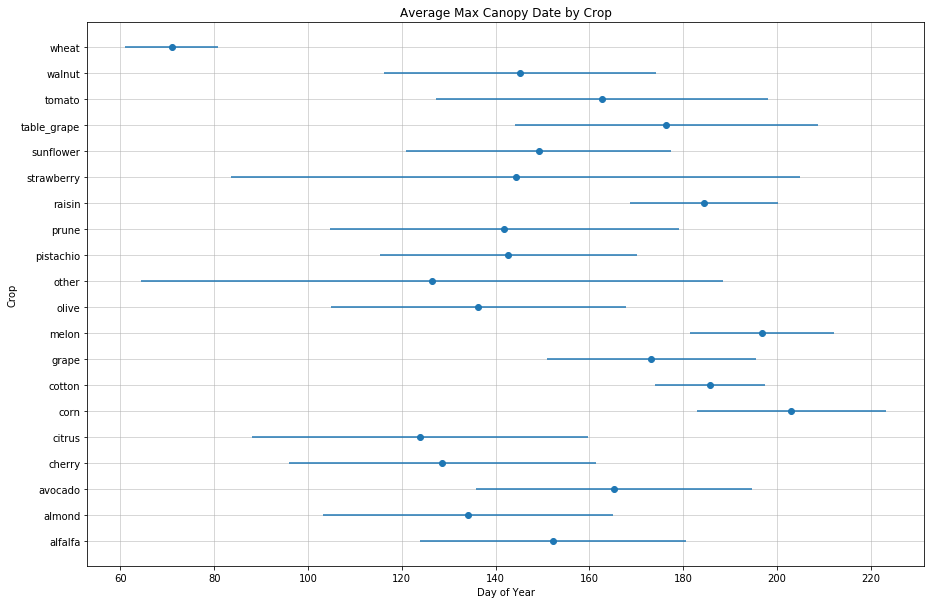

In [26]:
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.errorbar(df.average_max_date, df.crop, xerr=df.std_max_date, fmt='o')
plt.xlabel("Day of Year")
plt.ylabel("Crop")
plt.title("Average Max Canopy Date by Crop")
plt.grid(True, which = "both",linewidth = .5)
plt.show()